In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pymorphy2

import tensorflow as tf
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [43]:
df = pd.read_json('dataset-hackaton.json', lines=True)
df.head()

,title,dir
0,Раскладной П-образный диван BINGO,furniture
1,Диван раскладной угловой Каприз,furniture
2,Классический диван из кожи Кит - DDO10,furniture
3,Кровать Шелби,furniture
4,Кровать Слимо,furniture


In [44]:
df_test = pd.read_json('hideout-public.json', lines=True)
df_test.head()

,title
0,"Шланг GRINDA ""CLASSIC"" 1/2"" х 50 м 8-429001-1/..."
1,Триммер электрический DDE ET1600RV
2,Лестница 3-секционная алюминиевая TOR VL3-17
3,Полотенцесушитель Лесенка (полка) 40*80 электр...
4,Газонокосилка аккумуляторная HONDA HRG416XBPEE...


In [45]:
need_class = df.groupby('dir', as_index=False)\
    .agg({'title': 'count'})\
    .query('title > 40000')\
    .dir\
    .unique()

In [46]:
train = pd.DataFrame()
for i in need_class:
    s = df.query(f'dir == "{i}"').sample(n=40000, random_state=2)
    train = pd.concat([train, s])

In [47]:
need_clases_2 = df.groupby('dir', as_index=False)\
    .agg({'title': 'count'})\
    .query('title < 40000')\
    .dir\
    .unique()

In [48]:
for i in need_clases_2:
    s = df.query(f'dir == "{i}"')
    train = pd.concat([train, s])

In [49]:
train.shape

(625317, 2)

In [50]:
train.reset_index(inplace=True)
train = train.drop('index', axis=1)

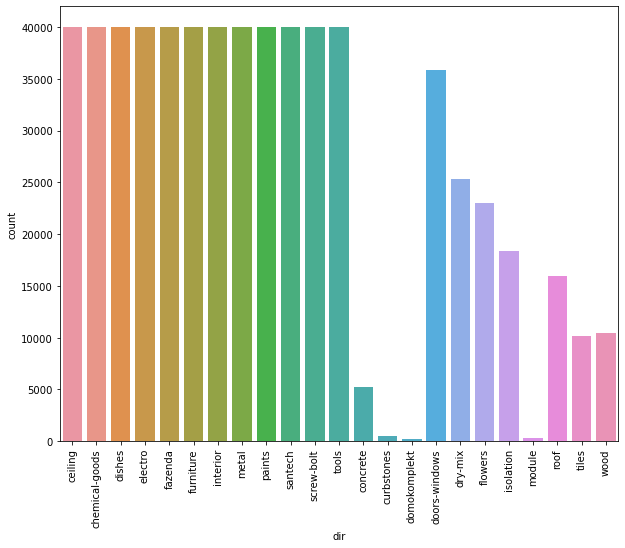

In [51]:
plt.figure(figsize=(10, 8))
sns.countplot(x='dir', data=train)
plt.xticks(rotation=90);

In [52]:
def clean(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','', text)
    text = re.sub(r'\n', '', text)
    text = re.sub('[a-zA-Z{}]', '', text)
    return text

In [53]:
df = train

In [54]:
df['title'] = df.title.apply(lambda x: clean(x))
df_test['title'] = df_test.title.apply(lambda x: clean(x))

In [55]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bors1n/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
df['title'] = df.title.apply(lambda x: nltk.word_tokenize(x))
df_test['title'] = df_test.title.apply(lambda x: nltk.word_tokenize(x))

In [57]:
from nltk.corpus import stopwords
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('russian')]
    return words

In [58]:
df['title'] = df.title.apply(lambda x: remove_stopwords(x))
df_test['title'] = df_test.title.apply(lambda x: remove_stopwords(x))

In [59]:
morph = pymorphy2.MorphAnalyzer()
def lem_word(text):
    return [morph.parse(w)[0].normal_form for w in text]

In [60]:
df['title'] = df.title.apply(lambda x: lem_word(x))
df_test['title'] = df_test.title.apply(lambda x: lem_word(x))

In [61]:
def combine_text(list_of_text):
    combine_text = ' '.join(list_of_text)
    return combine_text

In [62]:
df['title'] = df.title.apply(lambda x: combine_text(x))
df_test['title'] = df_test.title.apply(lambda x: combine_text(x))

In [63]:
df.to_csv('farpost_clean_train.csv')
df_test.to_csv('farpost_clean_test.csv')

In [3]:
max_nb_words = 50000
max_sequence_len = 250
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_nb_words)
tokenizer.fit_on_texts(df['title'].values)
word_index = tokenizer.word_index
print(len(word_index))

In [4]:
X = tokenizer.texts_to_sequences(df['title'].values)
X = pad_sequences(X, maxlen=max_sequence_len)
print(X.shape)

In [5]:
y = pd.get_dummies(df['dir']).values
print(y.shape)

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [68]:
model = Sequential()
model.add(Embedding(max_nb_words, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(23, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 23)                1173      
Total params: 5,086,623
Trainable params: 5,086,623
Non-trainable params: 0
_________________________________________________________________
None


In [1]:
epochs = 10
batch_size = 128

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

In [71]:
model.evaluate(X_test, y_test)

3909/3909 [==============================] - 328s 84ms/step - loss: 0.2114 - accuracy: 0.9512


[0.21139679849147797, 0.951216995716095]

In [72]:
X_2 = tokenizer.texts_to_sequences(df_test['title'].values)
X_2 = pad_sequences(X_2, maxlen=max_sequence_len)

In [73]:
sub = model.predict(X_2)

In [74]:
sub

array([[1.39665368e-04, 3.08037966e-06, 3.76288306e-11, ...,
        1.07861695e-07, 1.79241062e-03, 2.01273820e-09],
       [2.58692801e-08, 4.10012746e-07, 4.06290539e-12, ...,
        7.84582382e-12, 1.01739999e-04, 3.44214612e-07],
       [5.64609727e-05, 8.85107099e-08, 7.60594092e-04, ...,
        1.00142172e-09, 1.15847355e-02, 8.63817096e-01],
       ...,
       [1.00554321e-02, 4.42891942e-05, 1.22974569e-07, ...,
        1.36206199e-06, 1.49915749e-02, 1.76094833e-03],
       [7.15821926e-08, 7.72279918e-13, 8.31987948e-16, ...,
        1.30504247e-14, 9.99999762e-01, 5.28755506e-14],
       [8.18678370e-09, 2.48935295e-09, 2.22056775e-13, ...,
        8.93794994e-14, 5.39361463e-06, 6.81605385e-08]], dtype=float32)

In [75]:
sub_df = pd.DataFrame(sub, columns=pd.get_dummies(df.iloc[:, 1:], columns=['dir']).columns)

In [76]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                    .idxmax(axis=1)
                    .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                    .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [77]:
ans = undummify(sub_df)

In [78]:
ans

,dir
0,santech
1,fazenda
2,wood
3,santech
4,fazenda
...,...
42250,screw-bolt
42251,isolation
42252,fazenda
42253,tools


In [1]:
#попытка 6018245

In [79]:
ans.to_json('submission_3.json', orient='records', lines=True)